In [35]:
import sys
print(sys.executable)


c:\Users\91936\OneDrive\Desktop\Infosys\lstm_env\Scripts\python.exe


In [36]:
# ===============================
# Core Utilities
# ===============================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Force CPU usage (avoid CUDA warnings)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# ===============================
# Deep Learning - LSTM
# ===============================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [37]:
file_path = r"C:\Users\91936\Downloads\smart_home_6_months_dataset.csv"
df = pd.read_csv(file_path)
print("First 5 rows of the raw dataset:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nBasic statistics for numeric columns:")
print(df.describe())


First 5 rows of the raw dataset:
             timestamp  home_id         room        device  status  power_w  \
0  2025-01-01 00:00:00        1  Living Room            TV       0     0.00   
1  2025-01-01 00:00:00        1  Living Room           Fan       1    59.20   
2  2025-01-01 00:00:00        1  Living Room          Lamp       0     0.00   
3  2025-01-01 00:00:00        1  Living Room  Game Console       0     0.00   
4  2025-01-01 00:00:00        1      Kitchen  Refrigerator       1   148.59   

   energy_kwh  hour  day_of_week day_type  
0      0.0000     0            2  Weekday  
1      0.0592     0            2  Weekday  
2      0.0000     0            2  Weekday  
3      0.0000     0            2  Weekday  
4      0.1486     0            2  Weekday  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69504 entries, 0 to 69503
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    69

In [38]:
# Count missing values in each column
print("\nMissing values per column:")
print(df.isna().sum())

# Count duplicate rows
dup_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {dup_count}")

# Drop duplicate rows if any
df = df.drop_duplicates().reset_index(drop=True)


Missing values per column:
timestamp      0
home_id        0
room           0
device         0
status         0
power_w        0
energy_kwh     0
hour           0
day_of_week    0
day_type       0
dtype: int64

Number of duplicate rows: 0


In [39]:
df = df.set_index("timestamp")

# Simple view: energy usage by room (total)
if "energy_kwh" in df.columns and "room" in df.columns:
    energy_by_room = df.groupby("room")["energy_kwh"].sum()
    print("\nTotal energy consumption by room (kWh):")
    print(energy_by_room)

# Simple view: energy usage by device (total)
if "energy_kwh" in df.columns and "device" in df.columns:
    energy_by_device = df.groupby("device")["energy_kwh"].sum()
    print("\nTotal energy consumption by device (kWh):")
    print(energy_by_device)



Total energy consumption by room (kWh):
room
Bathroom         932.5954
Bedroom         2490.7034
Kitchen         4870.2780
Laundry Room     237.9049
Living Room      557.0035
Study            424.9215
Name: energy_kwh, dtype: float64

Total energy consumption by device (kWh):
device
AC                 2289.2347
Coffee Maker        690.4781
Desktop PC          339.3861
Fan                 261.4976
Game Console        214.7267
Lamp                141.3082
Laptop               85.5354
Microwave           783.9590
Oven               1588.8848
Refrigerator        651.5736
Stove              1155.3825
TV                  140.9397
Washing Machine     237.9049
Water Heater        932.5954
Name: energy_kwh, dtype: float64


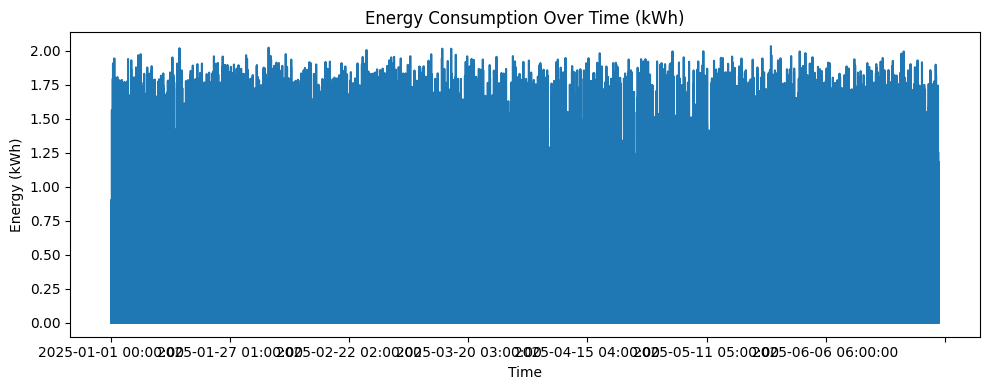

In [40]:
if "energy_kwh" in df.columns:
    plt.figure(figsize=(10, 4))
    df["energy_kwh"].plot()
    plt.title("Energy Consumption Over Time (kWh)")
    plt.xlabel("Time")
    plt.ylabel("Energy (kWh)")
    plt.tight_layout()
    plt.show()

In [41]:
# Ensure timestamp exists either as a column or index, and convert to DatetimeIndex

# CASE 1: timestamp is a column
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])
    df = df.set_index("timestamp")

# CASE 2: timestamp is already an index
else:
    df.index = pd.to_datetime(df.index, errors="coerce")
    df = df[~df.index.isna()]   # remove invalid timestamps

# Final check
print("Index type:", type(df.index))
print("Is DatetimeIndex?", isinstance(df.index, pd.DatetimeIndex))
print(df.index[:5])


Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Is DatetimeIndex? True
DatetimeIndex(['2025-01-01', '2025-01-01', '2025-01-01', '2025-01-01',
               '2025-01-01'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


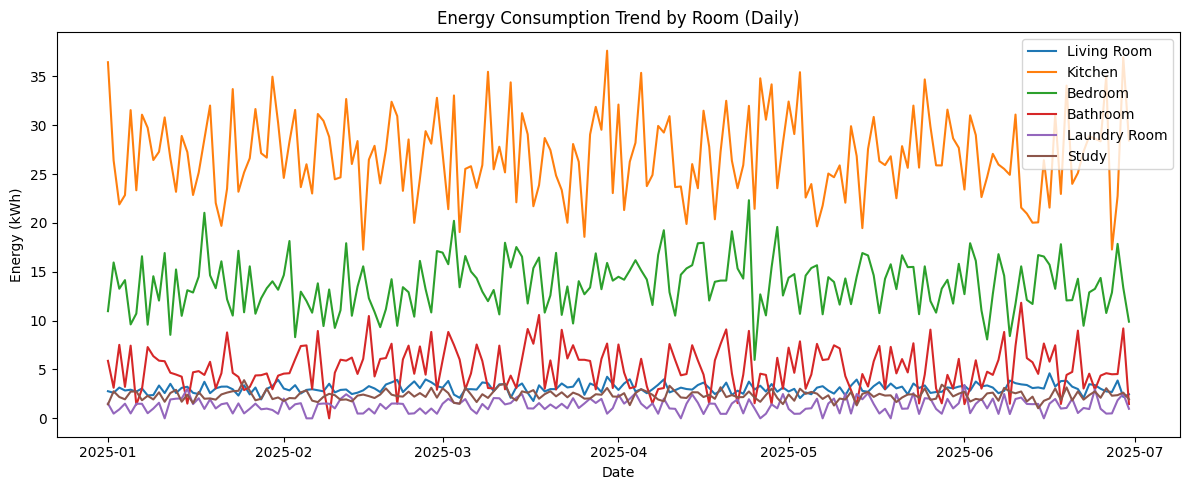

In [42]:
if "energy_kwh" in df.columns and "room" in df.columns:
    plt.figure(figsize=(12, 5))
    for room in df["room"].unique():
        room_series = df.loc[df["room"] == room, "energy_kwh"].resample("D").sum()
        plt.plot(room_series.index, room_series.values, label=room)

    plt.title("Energy Consumption Trend by Room (Daily)")
    plt.xlabel("Date")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Required columns missing: 'energy_kwh' and/or 'room'.")


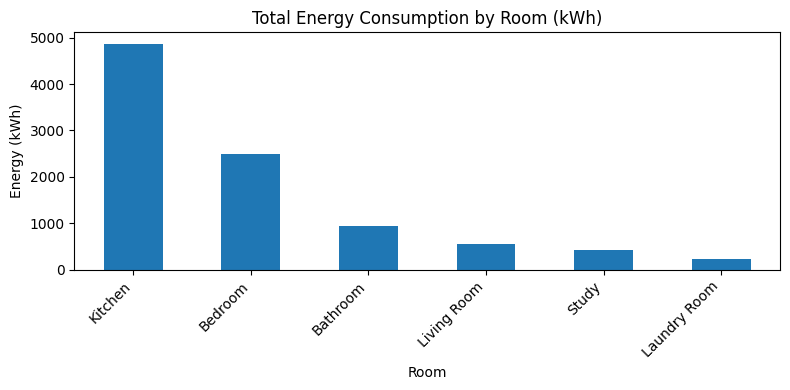

In [43]:
if "energy_kwh" in df.columns and "room" in df.columns:
    room_totals = df.groupby("room")["energy_kwh"].sum().sort_values(ascending=False)

    plt.figure(figsize=(8, 4))
    room_totals.plot(kind="bar")
    plt.title("Total Energy Consumption by Room (kWh)")
    plt.xlabel("Room")
    plt.ylabel("Energy (kWh)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [44]:
# MODULE 2 - Step 1
# Handle Missing Values + Outliers
# Convert power_w to numeric if needed
df["power_w"] = pd.to_numeric(df["power_w"], errors="coerce")
# Fill missing values with 0
df["power_w"] = df["power_w"].fillna(0)
# Outlier removal using IQR method
Q1 = df["power_w"].quantile(0.25)
Q3 = df["power_w"].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df["power_w"] = df["power_w"].clip(lower_limit, upper_limit)

print(" Missing values handled & outliers removed from power_w")

 Missing values handled & outliers removed from power_w


In [45]:
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

    # Remove invalid timestamps
    df = df.dropna(subset=["timestamp"])

    # Sort by time
    df = df.sort_values("timestamp")

    # Set timestamp as index for resampling
    df = df.set_index("timestamp")

else:
    # If timestamp already index → convert it
    df.index = pd.to_datetime(df.index, errors="coerce")
    df = df[~df.index.isna()]

# 2️ HOURLY RESAMPLING — using "h" (lowercase) to avoid warnings
df_hourly = df.resample("h").agg({
    "energy_kwh": "sum",
    "power_w": "mean"
}).fillna(0)

# 3️ DAILY RESAMPLING
df_daily = df.resample("D").agg({
    "energy_kwh": "sum",
    "power_w": "mean"
}).fillna(0)

print("✔ Timestamp converted and resampling completed successfully")
print("Hourly dataset shape :", df_hourly.shape)
print("Daily dataset shape  :", df_daily.shape)

df_hourly.head()

✔ Timestamp converted and resampling completed successfully
Hourly dataset shape : (4344, 2)
Daily dataset shape  : (181, 2)


,energy_kwh,power_w
timestamp,,
2025-01-01 00:00:00,1.9284,34.413125
2025-01-01 01:00:00,0.3817,23.715000
2025-01-01 02:00:00,1.8152,25.170625
2025-01-01 03:00:00,1.5778,33.235000
2025-01-01 04:00:00,0.5119,28.800000


In [46]:
df_scaled = df_hourly.copy()

# Scale energy_kwh
min_energy = df_hourly["energy_kwh"].min()
max_energy = df_hourly["energy_kwh"].max()

df_scaled["energy_kwh"] = (df_hourly["energy_kwh"] - min_energy) / (max_energy - min_energy)

# Scale power_w
min_power = df_hourly["power_w"].min()
max_power = df_hourly["power_w"].max()

df_scaled["power_w"] = (df_hourly["power_w"] - min_power) / (max_power - min_power)

print("✔ Scaling completed successfully (No sklearn used)")
df_scaled.head()

✔ Scaling completed successfully (No sklearn used)


,energy_kwh,power_w
timestamp,,
2025-01-01 00:00:00,0.222253,0.289315
2025-01-01 01:00:00,0.030295,0.169395
2025-01-01 02:00:00,0.208204,0.185712
2025-01-01 03:00:00,0.178740,0.276109
2025-01-01 04:00:00,0.046454,0.226395


In [47]:
# Split dataset into training, validation, and testing sets (time-based)

# Reset index so we can slice properly
df_scaled = df_scaled.reset_index()

total = len(df_scaled)

# Calculate split points
train_end = int(total * 0.70)   # 70%
val_end   = int(total * 0.85)   # 70–85% → validation

# Create splits
train_df = df_scaled.iloc[:train_end]
val_df   = df_scaled.iloc[train_end:val_end]
test_df  = df_scaled.iloc[val_end:]

print("✔ Dataset Split Completed")
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

train_df.head()


✔ Dataset Split Completed
Train size: 3040
Validation size: 652
Test size: 652


,timestamp,energy_kwh,power_w
0,2025-01-01 00:00:00,0.222253,0.289315
1,2025-01-01 01:00:00,0.030295,0.169395
2,2025-01-01 02:00:00,0.208204,0.185712
3,2025-01-01 03:00:00,0.178740,0.276109
4,2025-01-01 04:00:00,0.046454,0.226395


In [48]:
# Module 3 - Time-based features

# Make a copy
df_time = df_hourly.copy()

# Extract time-based features
df_time["hour"] = df_time.index.hour
df_time["day"] = df_time.index.day
df_time["day_of_week"] = df_time.index.dayofweek   # 0=Monday
df_time["week"] = df_time.index.isocalendar().week.astype(int)
df_time["month"] = df_time.index.month

df_time.head()


,energy_kwh,power_w,hour,day,day_of_week,week,month
timestamp,,,,,,,
2025-01-01 00:00:00,1.9284,34.413125,0,1,2,1,1
2025-01-01 01:00:00,0.3817,23.715000,1,1,2,1,1
2025-01-01 02:00:00,1.8152,25.170625,2,1,2,1,1
2025-01-01 03:00:00,1.5778,33.235000,3,1,2,1,1
2025-01-01 04:00:00,0.5119,28.800000,4,1,2,1,1


In [49]:
# Ensure index is datetime (safe check)
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, errors="coerce")
    df = df[~df.index.isna()]

# Aggregate energy usage per device
device_stats = df.groupby("device").agg(
    total_energy_kwh=("energy_kwh", "sum"),
    avg_energy_kwh=("energy_kwh", "mean"),
    max_energy_kwh=("energy_kwh", "max"),
    min_energy_kwh=("energy_kwh", "min")
).reset_index()

device_stats


,device,total_energy_kwh,avg_energy_kwh,max_energy_kwh,min_energy_kwh
0,AC,2289.2347,0.526988,1.4199,0.0000
1,Coffee Maker,690.4781,0.158950,0.9319,0.0000
2,Desktop PC,339.3861,0.078128,0.2952,0.0000
3,Fan,261.4976,0.030099,0.0726,0.0000
4,Game Console,214.7267,0.049431,0.2330,0.0000
5,Lamp,141.3082,0.016265,0.0468,0.0000
6,Laptop,85.5354,0.019690,0.0747,0.0000
7,Microwave,783.9590,0.180469,1.0473,0.0000
8,Oven,1588.8848,0.365765,2.0323,0.0000
9,Refrigerator,651.5736,0.149994,0.1804,0.1195


In [50]:
# Make a copy to avoid modifying original data
df_fe = df_hourly.copy()

# Lag Features (Past values)

# Energy consumption 1 hour before
df_fe["energy_lag_1h"] = df_fe["energy_kwh"].shift(1)

# Energy consumption 24 hours before (same hour previous day)
df_fe["energy_lag_24h"] = df_fe["energy_kwh"].shift(24)

# Fill missing lag values with 0 (initial rows)
df_fe[["energy_lag_1h", "energy_lag_24h"]] = df_fe[
    ["energy_lag_1h", "energy_lag_24h"]
].fillna(0)

# Moving Averages (Trends)

# 3-hour moving average (short-term trend)
df_fe["energy_ma_3h"] = df_fe["energy_kwh"].rolling(window=3, min_periods=1).mean()

# 24-hour moving average (daily trend)
df_fe["energy_ma_24h"] = df_fe["energy_kwh"].rolling(window=24, min_periods=1).mean()

df_fe.head()


,energy_kwh,power_w,energy_lag_1h,energy_lag_24h,energy_ma_3h,energy_ma_24h
timestamp,,,,,,
2025-01-01 00:00:00,1.9284,34.413125,0.0000,0.0,1.928400,1.928400
2025-01-01 01:00:00,0.3817,23.715000,1.9284,0.0,1.155050,1.155050
2025-01-01 02:00:00,1.8152,25.170625,0.3817,0.0,1.375100,1.375100
2025-01-01 03:00:00,1.5778,33.235000,1.8152,0.0,1.258233,1.425775
2025-01-01 04:00:00,0.5119,28.800000,1.5778,0.0,1.301633,1.243000


In [51]:

# Drop rows with any remaining missing values
df_fe = df_fe.dropna()

# Define input features (X)

feature_columns = [
    "power_w",
    "energy_lag_1h",
    "energy_lag_24h",
    "energy_ma_3h",
    "energy_ma_24h"
]

X = df_fe[feature_columns]

# Define target variable (y)

y = df_fe["energy_kwh"]

print("✔ Final ML feature set prepared")
print("X shape:", X.shape)
print("y shape:", y.shape)

X.head()


✔ Final ML feature set prepared
X shape: (4344, 5)
y shape: (4344,)


,power_w,energy_lag_1h,energy_lag_24h,energy_ma_3h,energy_ma_24h
timestamp,,,,,
2025-01-01 00:00:00,34.413125,0.0000,0.0,1.928400,1.928400
2025-01-01 01:00:00,23.715000,1.9284,0.0,1.155050,1.155050
2025-01-01 02:00:00,25.170625,0.3817,0.0,1.375100,1.375100
2025-01-01 03:00:00,33.235000,1.8152,0.0,1.258233,1.425775
2025-01-01 04:00:00,28.800000,1.5778,0.0,1.301633,1.243000


In [52]:
# MODULE 4 -
# Prepare data for Linear Regression (NumPy)
# Convert feature set and target to NumPy arrays
X_np = X.values
y_np = y.values.reshape(-1, 1)

# Add bias (intercept) term
X_np = np.hstack([np.ones((X_np.shape[0], 1)), X_np])

print("Data prepared for Linear Regression")
print("X shape:", X_np.shape)
print("y shape:", y_np.shape)


Data prepared for Linear Regression
X shape: (4344, 6)
y shape: (4344, 1)


In [53]:
# MODULE 4
# Train-Test Split (80% Train, 20% Test)

split_index = int(0.8 * len(X_np))

X_train, X_test = X_np[:split_index], X_np[split_index:]
y_train, y_test = y_np[:split_index], y_np[split_index:]

print("Train size:", len(X_train))
print("Test size :", len(X_test))


Train size: 3475
Test size : 869


In [54]:
# MODULE 4
# Train Linear Regression using Normal Equation

# θ = (XᵀX)⁻¹ Xᵀy
theta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

print("Linear Regression model trained")


Linear Regression model trained


In [55]:
# MODULE 4
# Predict energy usage on test data

y_pred = X_test @ theta

print("Predictions generated")


Predictions generated


In [56]:
# MODULE 4 
# Model Evaluation using MAE and RMSE

mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

print("Baseline Linear Regression Performance")
print("MAE :", mae)
print("RMSE:", rmse)


Baseline Linear Regression Performance
MAE : 0.565555512410614
RMSE: 0.7187722001194625


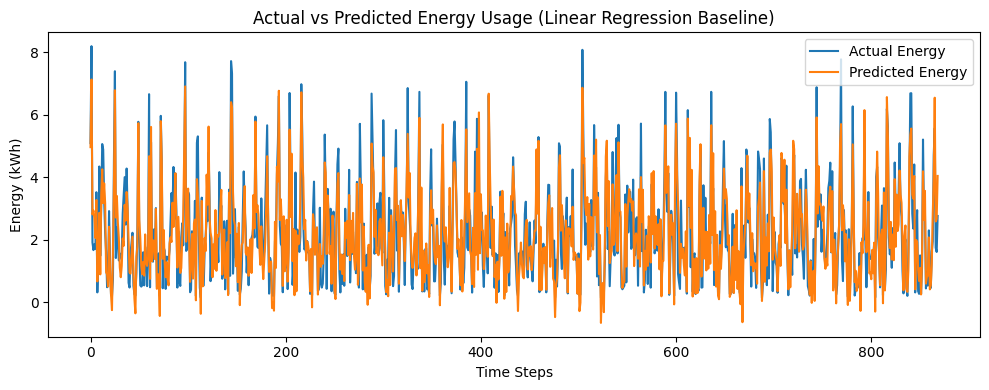

In [57]:
# MODULE 4
# Plot Actual vs Predicted Energy Usage

plt.figure(figsize=(10, 4))
plt.plot(y_test, label="Actual Energy")
plt.plot(y_pred, label="Predicted Energy")
plt.title("Actual vs Predicted Energy Usage (Linear Regression Baseline)")
plt.xlabel("Time Steps")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.tight_layout()
plt.show()


In [58]:
# MODULE 5 - Cell 2
# Create lag features and moving averages

df_scaled = df_scaled.sort_index()

df_scaled["energy_lag_1h"] = df_scaled["energy_kwh"].shift(1)
df_scaled["energy_lag_24h"] = df_scaled["energy_kwh"].shift(24)

df_scaled["energy_ma_3h"] = df_scaled["energy_kwh"].rolling(3).mean()
df_scaled["energy_ma_24h"] = df_scaled["energy_kwh"].rolling(24).mean()

df_scaled = df_scaled.dropna()

print("Feature columns ready:")
print(df_scaled.columns)


Feature columns ready:
Index(['timestamp', 'energy_kwh', 'power_w', 'energy_lag_1h', 'energy_lag_24h',
       'energy_ma_3h', 'energy_ma_24h'],
      dtype='object')


In [59]:
# MODULE 5 - Cell 3
# Prepare 3D sequential data

FEATURES = [
    "power_w",
    "energy_lag_1h",
    "energy_lag_24h",
    "energy_ma_3h",
    "energy_ma_24h"
]

TARGET = "energy_kwh"

data = df_scaled[FEATURES + [TARGET]].values

TIME_STEPS = 24  # 24-hour lookback

X, y = [], []

for i in range(TIME_STEPS, len(data)):
    X.append(data[i - TIME_STEPS:i, :-1])
    y.append(data[i, -1])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)   # (samples, 24, 5)
print("y shape:", y.shape)


X shape: (4296, 24, 5)
y shape: (4296,)


In [60]:
# MODULE 5 - Cell 4
# Split data

train_size = int(0.7 * len(X))
val_size = int(0.85 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:val_size], y[train_size:val_size]
X_test, y_test = X[val_size:], y[val_size:]

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (3007, 24, 5)
Validation: (644, 24, 5)
Test: (645, 24, 5)


In [61]:
# MODULE 5 - Cell 5
# LSTM model architecture

model = Sequential()

model.add(
    LSTM(
        64,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    )
)
model.add(Dropout(0.2))

model.add(LSTM(32))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 64)            17920     
                                                                 
 dropout_2 (Dropout)         (None, 24, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [62]:
# MODULE 5 - Cell 6
# Train the LSTM model

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,        # Hyperparameter
    batch_size=32,    # Hyperparameter
    verbose=1
)


Epoch 1/20
94/94 [==============================] - 3s 14ms/step - loss: 0.0433 - val_loss: 0.0398
Epoch 2/20
94/94 [==============================] - 1s 9ms/step - loss: 0.0382 - val_loss: 0.0363
Epoch 3/20
94/94 [==============================] - 1s 10ms/step - loss: 0.0343 - val_loss: 0.0325
Epoch 4/20
94/94 [==============================] - 1s 10ms/step - loss: 0.0318 - val_loss: 0.0278
Epoch 5/20
94/94 [==============================] - 1s 11ms/step - loss: 0.0284 - val_loss: 0.0246
Epoch 6/20
94/94 [==============================] - 1s 10ms/step - loss: 0.0266 - val_loss: 0.0252
Epoch 7/20
94/94 [==============================] - 1s 10ms/step - loss: 0.0261 - val_loss: 0.0244
Epoch 8/20
94/94 [==============================] - 1s 10ms/step - loss: 0.0252 - val_loss: 0.0242
Epoch 9/20
94/94 [==============================] - 1s 10ms/step - loss: 0.0250 - val_loss: 0.0237
Epoch 10/20
94/94 [==============================] - 1s 9ms/step - loss: 0.0250 - val_loss: 0.0242
Epoch 11/20

In [63]:
# MODULE 5 - Cell 7
# Evaluate LSTM

y_pred_lstm = model.predict(X_test).flatten()

mae_lstm = np.mean(np.abs(y_test - y_pred_lstm))
rmse_lstm = np.sqrt(np.mean((y_test - y_pred_lstm) ** 2))

print("LSTM Performance")
print("MAE :", mae_lstm)
print("RMSE:", rmse_lstm)


21/21 [==============================] - 0s 4ms/step
LSTM Performance
MAE : 0.11659987216659226
RMSE: 0.15045162176912807


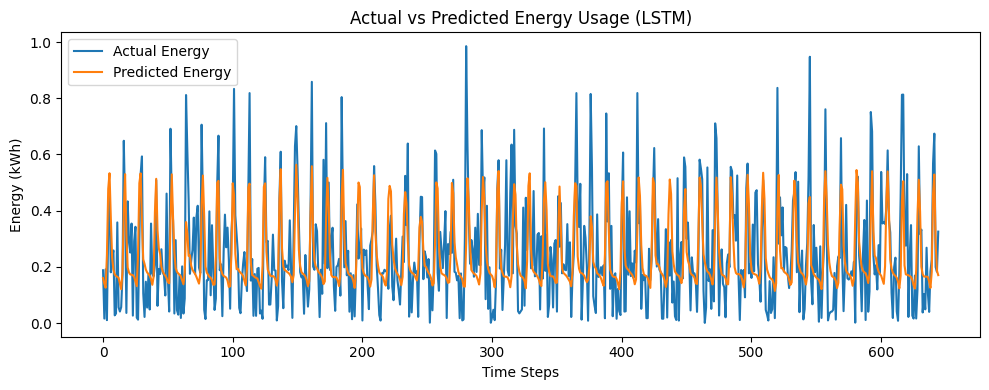

In [64]:
# MODULE 5 - Cell 8
# Plot Actual vs Predicted Energy Usage (LSTM)

plt.figure(figsize=(10, 4))
plt.plot(y_test, label="Actual Energy")
plt.plot(y_pred_lstm, label="Predicted Energy")
plt.title("Actual vs Predicted Energy Usage (LSTM)")
plt.xlabel("Time Steps")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.tight_layout()
plt.show()


In [65]:
# MODULE 5 - Cell 9
# Baseline vs LSTM comparison

print("Model Comparison")
print("-----------------------------")
print("Linear Regression MAE :", mae)
print("Linear Regression RMSE:", rmse)
print("LSTM MAE :", mae_lstm)
print("LSTM RMSE:", rmse_lstm)


Model Comparison
-----------------------------
Linear Regression MAE : 0.565555512410614
Linear Regression RMSE: 0.7187722001194625
LSTM MAE : 0.11659987216659226
LSTM RMSE: 0.15045162176912807


In [66]:
# MODULE 6 - Cell 2
# Calculate R² score for LSTM

r2_lstm = r2_score(y_test, y_pred_lstm)

print("LSTM Evaluation Metrics")
print("----------------------")
print("MAE :", mae_lstm)
print("RMSE:", rmse_lstm)
print("R²  :", r2_lstm)


LSTM Evaluation Metrics
----------------------
MAE : 0.11659987216659226
RMSE: 0.15045162176912807
R²  : 0.38016471745308156


In [68]:
# MODULE 6 - Cell 3
# Model selection based on RMSE

if rmse_lstm < rmse:
    best_model = "LSTM"
else:
    best_model = "Linear Regression"

print("Best Performing Model:", best_model)


Best Performing Model: LSTM


In [69]:
# MODULE 6 - Cell 4
# Save LSTM model

model.save("lstm_energy_model.h5")

print("✔ LSTM model saved as lstm_energy_model.h5")


✔ LSTM model saved as lstm_energy_model.h5


In [70]:
# MODULE 6 - Cell 5
# Flask-compatible prediction function

def predict_energy_lstm(input_sequence, trained_model):
    """
    input_sequence: numpy array of shape (1, 24, 5)
    trained_model: loaded LSTM model
    """
    prediction = trained_model.predict(input_sequence)
    return float(prediction[0][0])


In [71]:
# MODULE 6 - Cell 6
# Test prediction using one sample from test data

sample_input = X_test[0].reshape(1, X_test.shape[1], X_test.shape[2])

sample_prediction = predict_energy_lstm(sample_input, model)

print("Sample Actual Energy :", y_test[0])
print("Sample Predicted Energy :", sample_prediction)


1/1 [==============================] - 0s 14ms/step
Sample Actual Energy : 0.18787465094632333
Sample Predicted Energy : 0.1599615067243576


In [72]:
# MODULE 6 - Cell 7
# Load model to confirm saving works

from tensorflow.keras.models import load_model

loaded_model = load_model("lstm_energy_model.h5")

print("✔ Model loaded successfully for deployment")


✔ Model loaded successfully for deployment


In [73]:
# MODULE 7 - Cell 1
# Ensure timestamp is datetime index

if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

print("✔ Datetime index confirmed")


✔ Datetime index confirmed


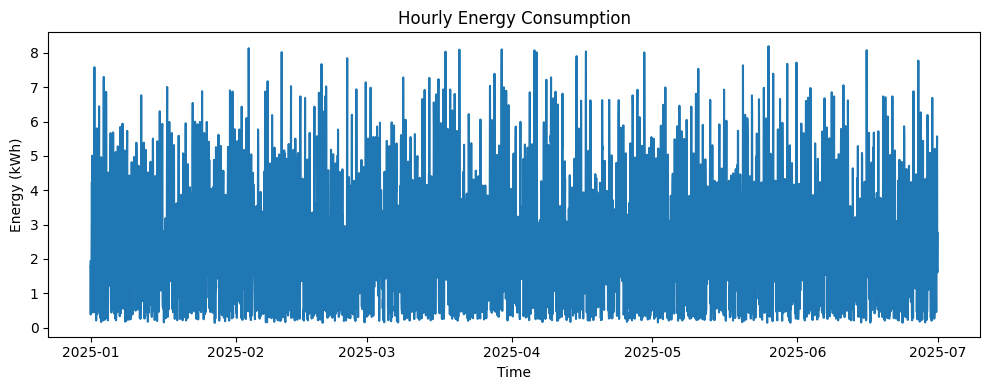

In [74]:
# MODULE 7 - Cell 2
# Hourly energy consumption

hourly_energy = df["energy_kwh"].resample("h").sum()

plt.figure(figsize=(10, 4))
plt.plot(hourly_energy)
plt.title("Hourly Energy Consumption")
plt.xlabel("Time")
plt.ylabel("Energy (kWh)")
plt.tight_layout()
plt.show()


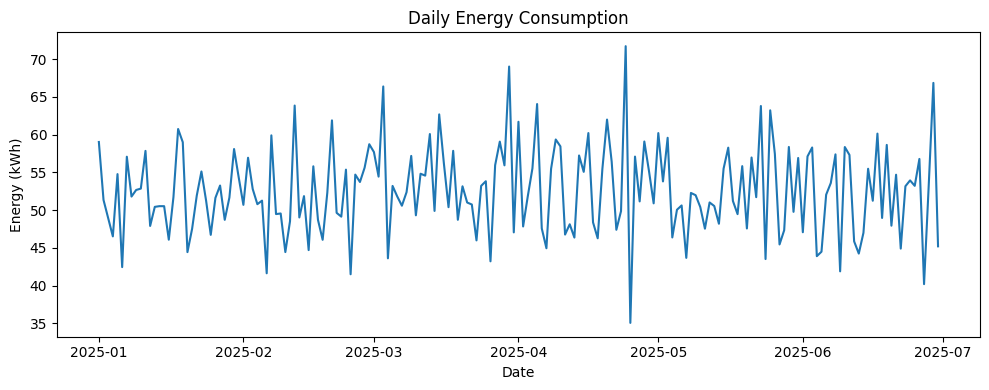

In [75]:
# MODULE 7 - Cell 3
# Daily energy consumption

daily_energy = df["energy_kwh"].resample("D").sum()

plt.figure(figsize=(10, 4))
plt.plot(daily_energy)
plt.title("Daily Energy Consumption")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.tight_layout()
plt.show()


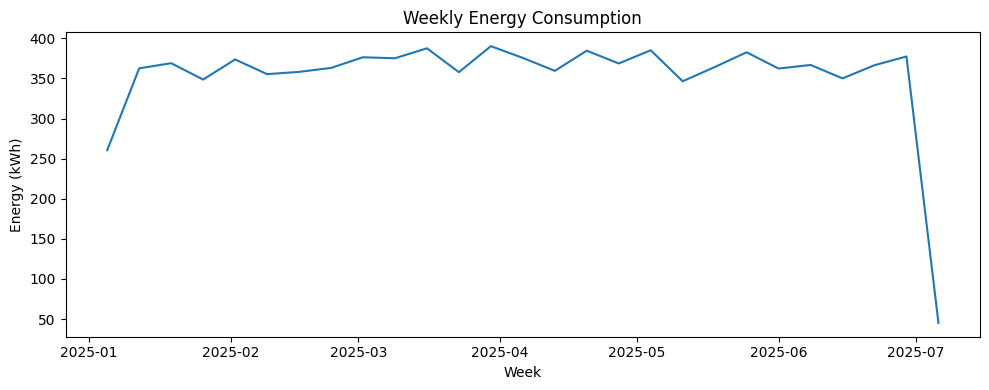

In [76]:
# MODULE 7 - Cell 4
# Weekly energy consumption

weekly_energy = df["energy_kwh"].resample("W").sum()

plt.figure(figsize=(10, 4))
plt.plot(weekly_energy)
plt.title("Weekly Energy Consumption")
plt.xlabel("Week")
plt.ylabel("Energy (kWh)")
plt.tight_layout()
plt.show()


C:\Users\91936\AppData\Local\Temp\ipykernel_37360\2222451424.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_energy = df["energy_kwh"].resample("M").sum()


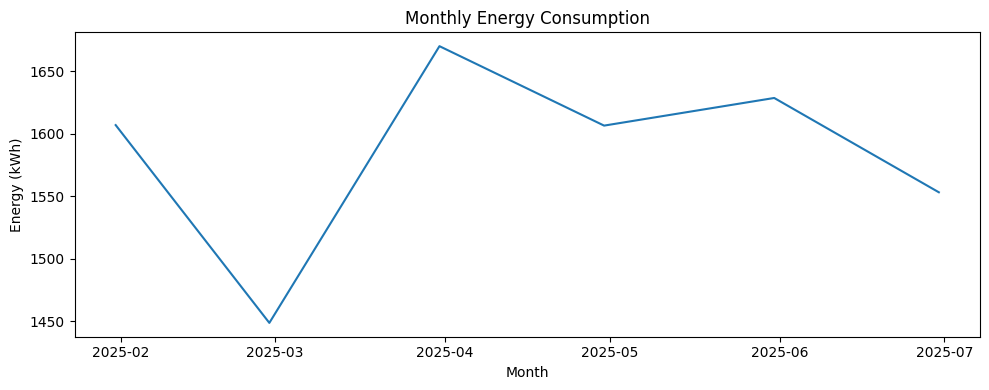

In [77]:
# MODULE 7 - Cell 5
# Monthly energy consumption

monthly_energy = df["energy_kwh"].resample("M").sum()

plt.figure(figsize=(10, 4))
plt.plot(monthly_energy)
plt.title("Monthly Energy Consumption")
plt.xlabel("Month")
plt.ylabel("Energy (kWh)")
plt.tight_layout()
plt.show()


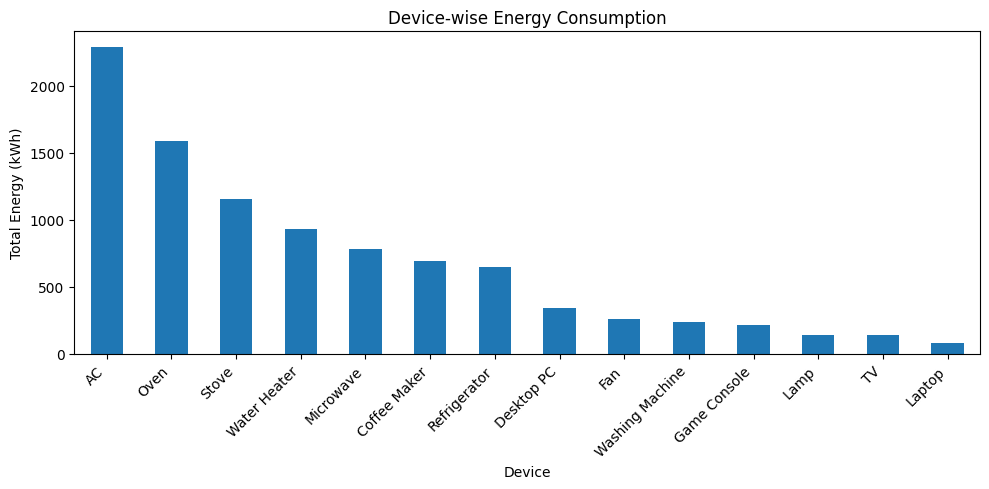

In [78]:
# MODULE 7 - Cell 6
# Device-wise energy consumption

device_energy = df.groupby("device")["energy_kwh"].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
device_energy.plot(kind="bar")
plt.title("Device-wise Energy Consumption")
plt.xlabel("Device")
plt.ylabel("Total Energy (kWh)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


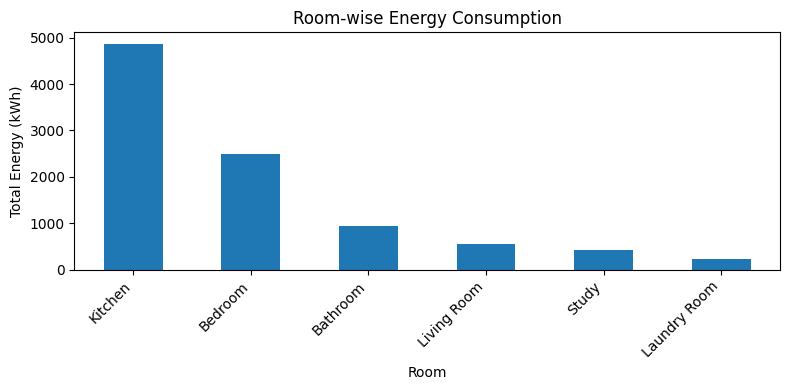

In [79]:
# MODULE 7 - Cell 7
# Room-wise energy consumption

room_energy = df.groupby("room")["energy_kwh"].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
room_energy.plot(kind="bar")
plt.title("Room-wise Energy Consumption")
plt.xlabel("Room")
plt.ylabel("Total Energy (kWh)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [80]:
# MODULE 7 - Cell 8
# Smart energy efficiency suggestions

avg_daily_energy = daily_energy.mean()

print("🔌 SMART ENERGY SUGGESTIONS")
print("---------------------------")

if avg_daily_energy > 5:
    print("• High daily energy usage detected.")
    print("• Consider switching off idle appliances.")
    print("• Use energy-efficient devices (5-star rated).")
else:
    print("• Energy usage is within efficient limits.")
    print("• Maintain current energy-saving practices.")

# Identify top energy-consuming device
top_device = device_energy.idxmax()
print(f"• Highest consuming device: {top_device}")
print("• Limit usage during peak hours.")


🔌 SMART ENERGY SUGGESTIONS
---------------------------
• High daily energy usage detected.
• Consider switching off idle appliances.
• Use energy-efficient devices (5-star rated).
• Highest consuming device: AC
• Limit usage during peak hours.
